# U-Net for sementic segmentation of images




# Objectives

This repository contains the implementation of a U-Net architecture for semantic segmentation of images using convolutional neural networks (CNNs). Semantic segmentation is a computer vision task where the goal is to classify each pixel in an image into a specific class, allowing for detailed understanding and localization of objects within the scene.

The U-Net architecture, introduced by Ronneberger et al. in 2015, has proven to be highly effective for image segmentation tasks. This repository serves as a guide and codebase for building and training a U-Net model for your own semantic segmentation projects.

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Default transforms
def transform_train(crop_size=224):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform


def transform_test():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform


# Data loader for the image segmentation data
class ImageSegmentation(Dataset):
    def __init__(self, root, split, transform=None, device="cpu"):
        self.root = root
        self.split = split
        self.transform = transform
        self.device = device

        self.dir = os.path.join(root, split)
        self.camera_files = sorted(os.listdir(os.path.join(self.dir, "Camera")))
        if self.split != "Test":
            self.seg_files = sorted(os.listdir(os.path.join(self.dir, "Labels")))

    def __len__(self):
        return len(self.camera_files)

    # Some good ideas here would be to crop a smaller section of the image
    # And add random flipping
    # Make sure the same augmentation is applied to image and label

    def image_augmentation(self, img_mat, label_mat):
        # Convert NumPy arrays to PIL Image
        img = Image.fromarray(img_mat)
        label = Image.fromarray(label_mat)

        # Random horizontal flipping using PyTorch transform
        if np.random.rand() > 0.5:
            transform_flip = transforms.RandomHorizontalFlip(p=1)
            img = transform_flip(img)
            label = transform_flip(label)

        # Random cropping using PyTorch transform
        transform_crop = transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(128, 128))
        img = transforms.functional.crop(img, i, j, h, w)
        label = transforms.functional.crop(label, i, j, h, w)

        # Convert PIL Images back to NumPy arrays
        img_mat = np.array(img)
        label_mat = np.array(label)

        return img_mat, label_mat

    def __getitem__(self, index):
        file_name = os.path.join(self.dir, "Camera", self.camera_files[index])
        img = Image.open(file_name)
        img_mat = np.copy(np.asarray(img)[:, :, :3])
        if self.split != "Test":
            labeled_img = Image.open(os.path.join(self.dir, "Labels", self.seg_files[index]))
            label_mat = np.copy(np.asarray(labeled_img)[:, :, :3])
        else:
            label_mat = np.zeros_like(img_mat)
        if self.split == "Train":
            img_mat, label_mat = self.image_augmentation(img_mat, label_mat)
        return self.transform(img_mat), torch.tensor(label_mat, device=self.device)



    # Combine data within the batch
    def collate_fn(self, data):
        B = len(data)
        img_batch = torch.stack([data[i][0] for i in range(B)]).to(self.device)
        label_batch = torch.stack([data[i][1] for i in range(B)]).to(self.device)
        return img_batch, label_batch


# Basic convolution block with a 2D convolution, ReLU, and BatchNorm layer
# Conv with kernel size 2, stride 2, and padding 0 decreases the size of the image by half
# Conv with kernel size 3, stride 1, padding 1 keeps the image size constant
class ConvBlockStudent(nn.Module):
    def __init__(self, c_in, c_out, ds=False, num_conv_layers=3):
        super().__init__()

        layers = []
        for _ in range(num_conv_layers):
            if ds:
                layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(c_out))
                layers.append(nn.Conv2d(c_out, c_out, kernel_size=3, stride=2, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(c_out))
            else:
                layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(c_out))
            c_in = c_out  # Update input channels for the next layer

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



# This is a basic U Net class. The decoder downsamples the image resolution at each level
# The encoder fuses information from the same resolution from the encoder at each level
# With a convolution operation.

# In the encoder, we perform upsampling to ensure the same resolution with simple
# bilinear interpolation. An alternative to this is transposed convolution:
# https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
# https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
class UNetStudent(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pre = ConvBlockStudent(3, 16)

        self.down1 = ConvBlockStudent(16, 32, ds=True)

        self.down2 = ConvBlockStudent(32, 64, ds=True)

        self.up1 = ConvBlockStudent(64+32, 32)

        self.up0 = ConvBlockStudent(32+16, 32)

        self.out = nn.Conv2d(32, num_classes, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x0 = self.pre(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)

        # Going up 1st layer
        B, __, H, W = x1.shape
        x2 = F.interpolate(x2, (H, W))
        x2 = torch.cat([x1, x2], dim=1)
        x1 = self.up1(x2)

        # Going up 0th layer
        B, __, H, W = x0.shape
        x1 = F.interpolate(x1, (H, W))
        x1 = torch.cat([x0, x1], dim=1)
        x = self.up0(x1)
        return self.out(x)


def IoU(targets, predictions, num_classes, ignore_index=0):
  intersections = torch.zeros(num_classes, device=targets.device)
  unions = torch.zeros_like(intersections)
  counts = torch.zeros_like(intersections)

  valid_mask = (targets!=ignore_index)
  targets = targets[valid_mask]
  predictions = predictions[valid_mask]
  # Loop over classes and update the counts, unions, and intersections
  for c in range(num_classes):


    pred_mask = predictions == c
    targ_mask = targets == c

    intersections[c] = torch.sum(pred_mask & targ_mask).float()
    unions[c] = torch.sum(pred_mask | targ_mask).float()
    counts[c] = torch.sum(targ_mask).float()
    # Add small value to avoid division by 0
    # Make sure to keep the small smoothing constant to match the autograder
    unions[c] = unions[c] + 0.00001

  # Per-class IoU
  # Make sure to set iou for classes with no points to 1
  iou = None
  iou = intersections/unions
  mask = (counts>0) & (torch.arange(num_classes,device=targets.device)!=ignore_index)

  # Calculate mean, ignoring ignore index
  miou = None
  miou = torch.mean(iou[mask])
  iou[counts==0] = 1.0
  return iou, miou

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab.
Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['UNet.ipynb',  'Problem2.py', 'Labels.txt']
```

In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "ROB 535/hw4/UNet/UNet"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', '__pycache__', 'Data', 'Problem2.py', 'UNet.ipynb']


Next we have some standard imports

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

In [ ]:
# from Problem2 import *
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

Next we will check if a GPU is available

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Data Visualization

In this assignment we will be working with camera images and pixel-wise semantic segmentation labels.

First, download the data from https://curly-dataset-public.s3.us-east-2.amazonaws.com/NA565/UNet/StudentData/Student.zip and unzip it to create a Train, Test, and Val folder. Place the files into a Data folder and add the path in the cell below. Move the `Labels.txt` file to Data folder.



Run the cells below to visualize some of the example images from the dataset.

In [ ]:
batch_size = 2
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, "Data")

trainset = ImageSegmentation(DATA_PATH, "Train", transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, collate_fn=trainset.collate_fn)

valset = ImageSegmentation(DATA_PATH, "Val", transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, collate_fn=valset.collate_fn)

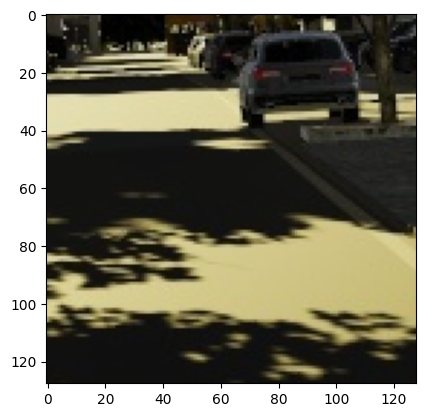

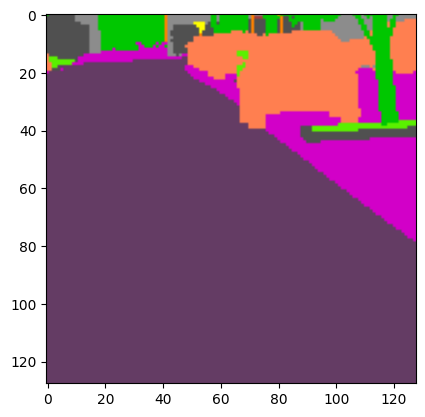

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # un-normalize
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_labels(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
demo_image = images[0, :, :, :]
imshow(demo_image)
# show labels
demo_label = labels[0, :, :, :]
imshow_labels(demo_label)

Notice how the ground truth is a color-coded image? The cell below takes the colors and converts each color to an integer label for our network to learn.

In [ ]:
label_file = open(os.path.join(DATA_PATH, "Labels.txt"), "r")
class_dict = {}

i = 0
label_file.readline()
for line in label_file:
    text = line.split("\n")[0]
    tokens = text.split(" ")
    rgb = np.array([int(tokens[1]), int(tokens[2]), int(tokens[3])])
    class_dict[i] = rgb
    i += 1

# Convert colored image to labels
def to_labels(label_img, color_to_label):
    B, H, W, C = label_img.shape
    labels = torch.zeros((B, H, W, 1), device=label_img.device)
    for i, rgb in color_to_label.items():
        mask = (label_img[:, :, :, 0] == rgb[0]) & (label_img[:, :, :, 1] == rgb[1]) & (label_img[:, :, :, 2] == rgb[2])
        labels[mask] = i
    return labels

## Training

The following cell trains a network on the semantic segmentation data.

In [ ]:
def train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion):
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      # Train
      net.train()
      total_loss = 0
      i = 0
      loop = tqdm(trainloader)
      for data in loop:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = net(inputs)
          B, C, H, W = outputs.shape
          outputs = outputs.permute(0, 2, 3, 1)
          outputs = outputs.reshape(-1, C)
          labels = to_labels(labels, class_dict)
          labels = labels.long().view(-1)


          # backward + optimize
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          loop.set_description("Training")
          total_loss += loss.detach().item()
          i += 1
          loop.set_postfix(loss=total_loss / i)

      # Validate
      net.eval()
      loop = tqdm(val_loader)
      loop.set_description("Validation")
      with torch.no_grad():
        all_targets = []
        all_preds = []
        for data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Forward pass
            outputs = net(inputs)
            B, C, H, W = outputs.shape
            outputs = outputs.permute(0, 2, 3, 1)
            outputs = outputs.reshape(-1, C)
            labels = to_labels(labels, class_dict)
            labels = labels.long().view(-1)

            # Targets and predictions for iou
            _, predicted = torch.max(outputs, 1)
            all_targets.append(labels)
            all_preds.append(predicted)
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        iou, miou = IoU(all_targets, all_preds, 15)

        # print statistics
        print(f'epochs: {epoch + 1} mIoU Val: {100 * miou.item():.3f}')
  print('Finished Training')
  return net

## Your Turn
Great! That was an easy assignment so far. Now comes the tricky part though. Now it is your turn to modify the training pipeline, hyper-parameters, and network architecture to improve the performance. Below are some ideas you can try:



1.   Implement image_augmentation with random cropping and flipping.
2.   Add more convolution layers to each level of the U Net.
3.   Change the channel sizes within the U Net.
4.   Change the learning rate, batch size, and number of epochs.
5.   Add weights to the CrossEntropyLoss to weight classes with fewer occurences more.
6.   Modify the training code to save the model weights from the epoch with the highest mIoU on the validation set.
7.   There are many more options... you choose!



In [ ]:
num_classes = 15
net = UNetStudent(num_classes).to(device)

# Hyper-parameters
lr = 0.001
num_epochs = 5
batch_size = 2

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
trainset = ImageSegmentation(DATA_PATH, "Train", transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, collate_fn=trainset.collate_fn)

valset = ImageSegmentation(DATA_PATH, "Val", transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, collate_fn=valset.collate_fn)

In [ ]:
net = train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion)
torch.save(net.state_dict(), PATH)

Training:   5%|▍         | 8/170 [00:03<01:02,  2.60it/s, loss=1.74]


KeyboardInterrupt: ignored

When you are happy with your results on the validation set, run the following cells to save the weights and generate predictions on the test set. The entire score from this assignment will be based on the mIoU as described above.

In [ ]:
net = UNetStudent(num_classes).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
testset = ImageSegmentation(DATA_PATH, "Test", transform=transform_test(), device=device)

In [ ]:
# Test
i = 0
net.eval()
save_dir = os.path.join(DATA_PATH, "Test", "Problem2_Predictions")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

i = 0
with torch.no_grad():
  for inputs, __ in iter(testset):
    # We are only evaluating every tenth image due to memory constraints on
    # Auto-grader
    if i % 10 == 0:
      C, H, W = inputs.shape
      outputs = net(inputs.view(1, C, H, W).to(device))
      B, C, H, W = outputs.shape
      outputs = outputs.permute(0, 2, 3, 1)
      predictions = outputs.argmax(dim=3).view(H, W)
      predictions_np = predictions.detach().cpu().numpy().astype(np.uint8)
      save_path = os.path.join(save_dir, str(i).zfill(6) + ".label")
      predictions_np.tofile(save_path)
    i += 1

# Visualize predictions
Next, we will load the saved weights and visualize some predictions compared to the ground truth.

In [ ]:
net = UNetStudent(num_classes).to(device)
net.load_state_dict(torch.load(PATH))

In [ ]:
# Convert colored image to labels
def label_to_image(label_img, color_to_label):
    B, H, W = label_img.shape
    colored_img = torch.zeros((B, H, W, 3), device=label_img.device, dtype=torch.uint8)
    for i, rgb in color_to_label.items():
        mask = label_img == i
        colored_img[mask, :] = torch.tensor(rgb, device=label_img.device, dtype=torch.uint8)
    return colored_img

Ground Truth


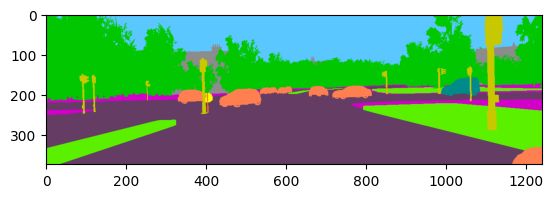

Prediction


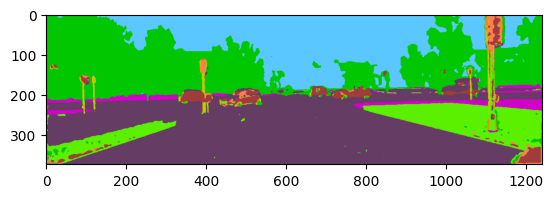

In [ ]:
with torch.no_grad():
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Make predictions
    # Forward pass
    outputs = net(images)
    B, C, H, W = outputs.shape
    outputs = outputs.permute(0, 2, 3, 1)
    # Targets and predictions for iou
    _, predicted = torch.max(outputs, 3)
    predicted_img = label_to_image(predicted, class_dict)
    # show labels
    print("Ground Truth")
    demo_label = labels[0, :, :, :]
    imshow_labels(demo_label)
    # Show predictions
    print("Prediction")
    demo_pred = predicted_img[0, :, :, :]
    imshow_labels(demo_pred)